# Magnus Formulation of the SRG

## The Pairing Modeal

In [4]:
from fractions import Fraction as Fr
 
def bernoulli(n):
    A = [0] * (n+1)
    for m in range(n+1):
        A[m] = Fr(1, m+1)
        for j in range(m, 0, -1):
          A[j-1] = j*(A[j-1] - A[j])
    return float(A[0]) # (which is Bn)
 
#bn = [(i, bernoulli(i)) for i in range(61)]
#bn = [(i, b) for i,b in bn if b]
#width = max(len(str(b.numerator)) for i,b in bn)
#for i,b in bn:
#    print('B(%2i) = %*i/%i' % (i, width, b.numerator, b.denominator))

bernoulli(1)

0.5

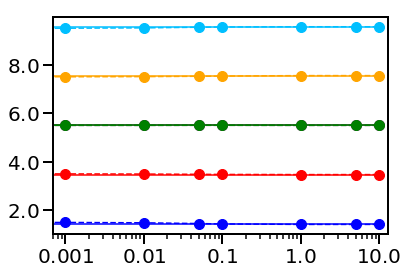

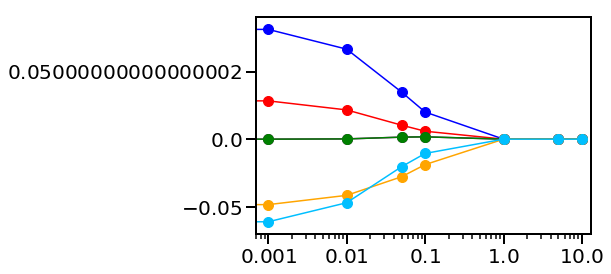

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


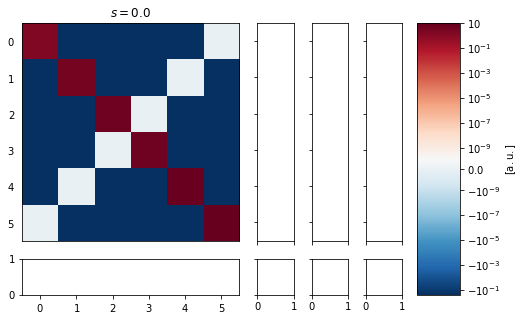

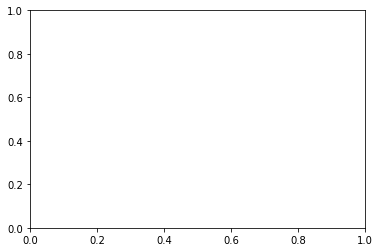

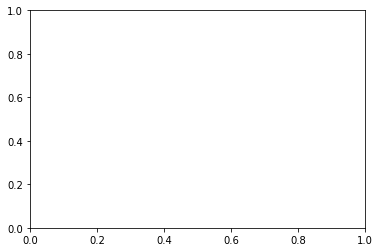

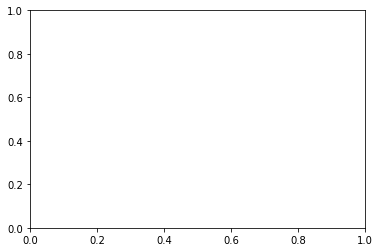

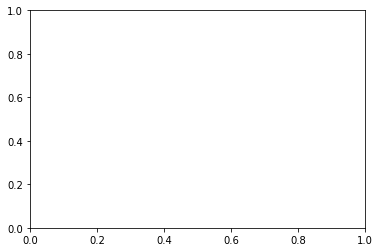

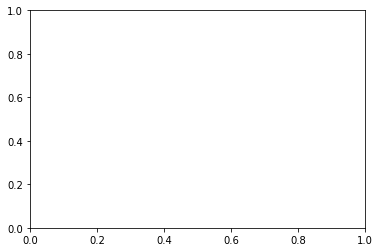

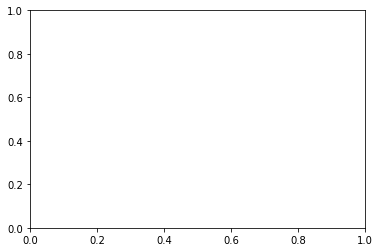

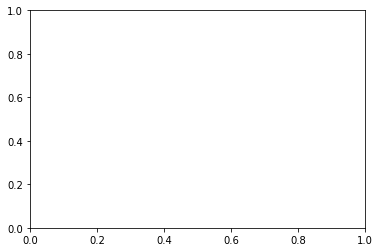

In [5]:
#!/usr/bin/env python

#------------------------------------------------------------------------------
# srg_pairing.py
#
# author:   H. Hergert 
# version:  1.1.0
# date:     Nov 18, 2016
# 
# tested with Python v2.7
# 
# Solves the pairing model for four particles in a basis of four doubly 
# degenerate states by means of a Similarity Renormalization Group (SRG)
# flow.
#
#------------------------------------------------------------------------------


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import SymLogNorm, Normalize
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

import numpy as np
from numpy import array, dot, diag, reshape
from scipy.linalg import eigvalsh
from scipy.integrate import odeint


#------------------------------------------------------------------------------
# plot helpers
#------------------------------------------------------------------------------
def myLabels(x, pos):
    '''format tick labels using LaTeX-like math fonts'''
    return '$%s$'%x

def myPlotSettings(ax, formatter):
    '''save these settings for use in other plots'''
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='both',which='major',width=1.5,length=8)
    ax.tick_params(axis='both',which='minor',width=1.5,length=5)
    ax.tick_params(axis='both',width=2,length=10,labelsize=20)
    for s in ['left', 'right', 'top', 'bottom']:
        ax.spines[s].set_linewidth(2)
    ax.set_xlim([0.0007,13])  
    return

#------------------------------------------------------------------------------
# plot routines
#------------------------------------------------------------------------------
def plot_diagonals(data, eigenvalues, flowparams, delta, g):
    '''plot eigenvalues and diagonals'''
    dim       = len(data)
    formatter = FuncFormatter(myLabels)
    markers   = ['o' for i in range(dim)]
    cols      = ['blue', 'red', 'purple', 'green', 'orange', 'deepskyblue']

    # diagonals vs. eigenvalues on absolute scale
    fig, ax = plt.subplots()
    for i in range(dim):
        plt.semilogx(flowparams, [eigenvalues[i] for e in range(flowparams.shape[0])], color=cols[i], linestyle='solid')
        plt.semilogx(flowparams, data[i], color=cols[i], linestyle='dashed', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()

    # difference between diagonals and eigenvalues
    fig, ax = plt.subplots()
    for i in range(dim):
        plot_diff = plt.semilogx(flowparams, data[i]-eigenvalues[i], color=cols[i], linestyle='solid', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag-eval_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()
    return

#------------------------------------------------------------------------------
# plot matrix snapshots
#------------------------------------------------------------------------------
def plot_snapshots(Hs, flowparams, delta, g):
    fig  = plt.figure(1, (10., 5.))
    grid = AxesGrid(fig, 111,                       # similar to subplot(111)
                     nrows_ncols=(2, Hs.shape[0]/2),  # creates grid of axes
                     axes_pad=0.25,                 # pad between axes in inch.
                     label_mode='L',                # put labels on left, bottom
                     cbar_mode='single',            # one color bar (default: right of last image in grid)
                     cbar_pad=0.20,                 # insert space between plots and color bar
                     cbar_size='10%'                # size of colorbar relative to last image
                     )

    # create individual snapshots - figures are still addressed by single index,
    # despite multi-row grid
    for s in range(Hs.shape[0]):
        img = grid[s].imshow(Hs[s], 
                            cmap=plt.get_cmap('RdBu_r'),                                  # choose color map
                            interpolation='nearest',       
                            norm=SymLogNorm(linthresh=1e-10,vmin=-0.5*g,vmax=10*delta),   # normalize 
                            vmin=-0.5*g,                                                  # min/max values for data
                            vmax=10*delta
                            )

        # tune plots: switch off tick marks, ensure that plots retain aspect ratio
        grid[s].set_title('$s=%s$'%flowparams[s])
        grid[s].tick_params(      
  
        bottom='off',      
        top='off',
        left='off',      
        right='off'
        )
  
        grid[s].set_xticks([0,1,2,3,4,5])
        grid[s].set_yticks([0,1,2,3,4,5])
        grid[s].set_xticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])
        grid[s].set_yticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])

        cbar = grid.cbar_axes[0]
        plt.colorbar(img, cax=cbar, 
          ticks=[ -1.0e-1, -1.0e-3, -1.0e-5, -1.0e-7, -1.09e-9 , 0., 
                 1.0e-9, 1.0e-7, 1.0e-5, 1.0e-3, 0.1, 10.0]
        )

        cbar.axes.set_yticklabels(['$-10^{-1}$', '$-10^{-3}$', '$-10^{-5}$', '$-10^{-7}$', 
                             '$-10^{-9}$', '$0.0$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', 
                             '$10^{-3}$', '$10^{-1}$', '$10$'])
        cbar.set_ylabel('$\mathrm{[a. u.]}$') 


        plt.savefig("srg_pairing_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
        plt.show()

    return

#------------------------------------------------------------------------------
# SRG 
#------------------------------------------------------------------------------

# Hamiltonian for the pairing model
def Hamiltonian(delta,g):

  H = array(
      [[2*delta-g,    -0.5*g,     -0.5*g,     -0.5*g,    -0.5*g,          0.],
       [   -0.5*g, 4*delta-g,     -0.5*g,     -0.5*g,        0.,     -0.5*g ], 
       [   -0.5*g,    -0.5*g,  6*delta-g,         0.,    -0.5*g,     -0.5*g ], 
       [   -0.5*g,    -0.5*g,         0.,  6*delta-g,    -0.5*g,     -0.5*g ], 
       [   -0.5*g,        0.,     -0.5*g,     -0.5*g, 8*delta-g,     -0.5*g ], 
       [       0.,    -0.5*g,     -0.5*g,     -0.5*g,    -0.5*g, 10*delta-g ]]
    )

  return H

# commutator of matrices
def commutator(a,b):
  return dot(a,b) - dot(b,a)

# derivative / right-hand side of the flow equation
def derivative(y, t, dim):

  # reshape the solution vector into a dim x dim matrix
  H = reshape(y, (dim, dim))

  # extract diagonal Hamiltonian...
  Hd  = diag(diag(H))

  # ... and construct off-diagonal the Hamiltonian
  Hod = H-Hd

  # calculate the generator
  eta = commutator(Hd, Hod)

  # dH is the derivative in matrix form 
  dH  = commutator(eta, H)

  # convert dH into a linear array for the ODE solver
  dydt = reshape(dH, -1)
    
  return dydt



#------------------------------------------------------------------------------
# Main program
#------------------------------------------------------------------------------

def main():
  g     = 0.5
  delta = 1

  H0    = Hamiltonian(delta, g)
  dim   = H0.shape[0]

  # calculate exact eigenvalues
  eigenvalues = eigvalsh(H0)

  # turn initial Hamiltonian into a linear array
  y0  = reshape(H0, -1)                 

  # flow parameters for snapshot images
  flowparams = array([0.,0.001,0.01,0.05,0.1, 1., 5., 10.])

  # integrate flow equations - odeint returns an array of solutions,
  # which are 1d arrays themselves
  ys  = odeint(derivative, y0, flowparams, args=(dim,))

  # reshape individual solution vectors into dim x dim Hamiltonian
  # matrices
  Hs  = reshape(ys, (-1, dim,dim))

  # print Hs[-1]
  # print eigvalsh(Hs[-1])

  data = []
  for h in Hs:
    data.append(diag(h))
  data = zip(*data)

  plot_diagonals(data, eigenvalues, flowparams, delta, g)
  plot_snapshots(Hs, flowparams, delta, g)

#------------------------------------------------------------------------------
# make executable
#------------------------------------------------------------------------------
if __name__ == "__main__": 
  main()

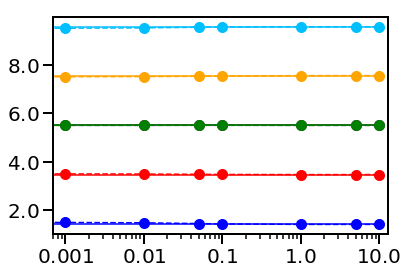

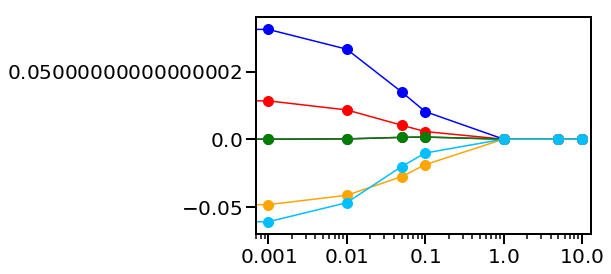

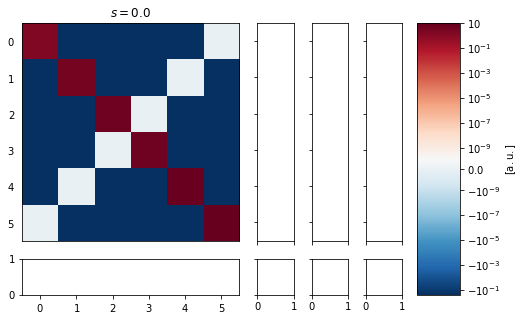

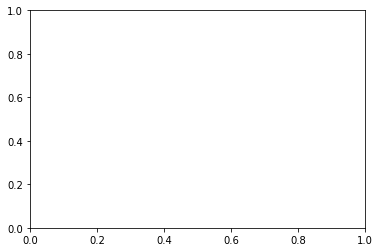

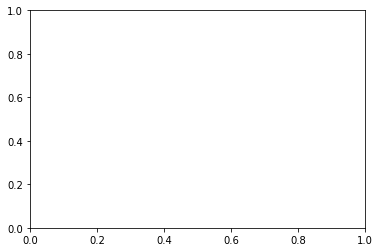

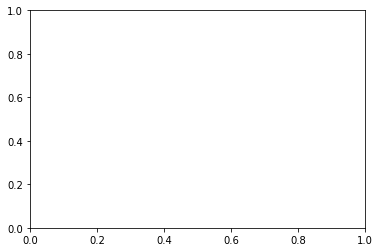

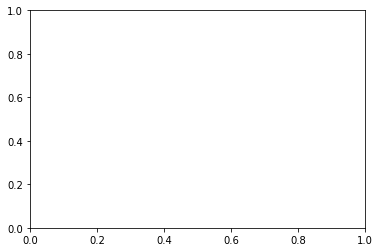

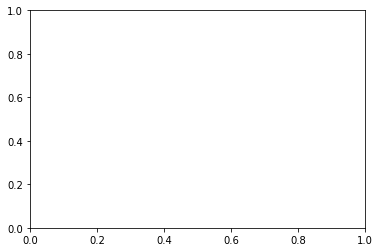

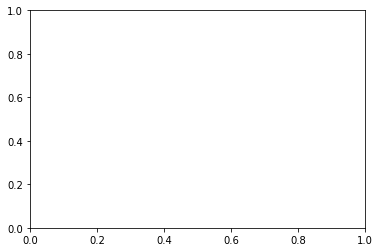

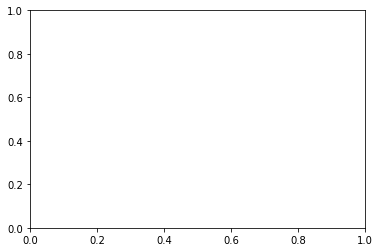

In [22]:
#!/usr/bin/env python

#------------------------------------------------------------------------------
# srg_pairing.py
#
# author:   H. Hergert 
# version:  1.1.0
# date:     Nov 18, 2016
# 
# tested with Python v2.7
# 
# Solves the pairing model for four particles in a basis of four doubly 
# degenerate states by means of a Similarity Renormalization Group (SRG)
# flow.
#
#------------------------------------------------------------------------------


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import SymLogNorm, Normalize
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

import numpy as np
from numpy import array, dot, diag, reshape
from scipy.linalg import eigvalsh
from scipy.integrate import odeint
import math
from scipy.linalg import expm

#------------------------------------------------------------------------------
# plot helpers
#------------------------------------------------------------------------------
def myLabels(x, pos):
    '''format tick labels using LaTeX-like math fonts'''
    return '$%s$'%x

def myPlotSettings(ax, formatter):
    '''save these settings for use in other plots'''
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='both',which='major',width=1.5,length=8)
    ax.tick_params(axis='both',which='minor',width=1.5,length=5)
    ax.tick_params(axis='both',width=2,length=10,labelsize=20)
    for s in ['left', 'right', 'top', 'bottom']:
        ax.spines[s].set_linewidth(2)
    ax.set_xlim([0.0007,13])  
    return

#------------------------------------------------------------------------------
# plot routines
#------------------------------------------------------------------------------
def plot_diagonals(data, eigenvalues, flowparams, delta, g):
    '''plot eigenvalues and diagonals'''
    dim       = len(data)
    formatter = FuncFormatter(myLabels)
    markers   = ['o' for i in range(dim)]
    cols      = ['blue', 'red', 'purple', 'green', 'orange', 'deepskyblue']

    # diagonals vs. eigenvalues on absolute scale
    fig, ax = plt.subplots()
    for i in range(dim):
        plt.semilogx(flowparams, [eigenvalues[i] for e in range(flowparams.shape[0])], color=cols[i], linestyle='solid')
        plt.semilogx(flowparams, data[i], color=cols[i], linestyle='dashed', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()

    # difference between diagonals and eigenvalues
    fig, ax = plt.subplots()
    for i in range(dim):
        plot_diff = plt.semilogx(flowparams, data[i]-eigenvalues[i], color=cols[i], linestyle='solid', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag-eval_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()
    return

#------------------------------------------------------------------------------
# plot matrix snapshots
#------------------------------------------------------------------------------
def plot_snapshots(Hs, flowparams, delta, g):
    fig  = plt.figure(1, (10., 5.))
    grid = AxesGrid(fig, 111,                       # similar to subplot(111)
                     nrows_ncols=(2, Hs.shape[0]/2),  # creates grid of axes
                     axes_pad=0.25,                 # pad between axes in inch.
                     label_mode='L',                # put labels on left, bottom
                     cbar_mode='single',            # one color bar (default: right of last image in grid)
                     cbar_pad=0.20,                 # insert space between plots and color bar
                     cbar_size='10%'                # size of colorbar relative to last image
                     )

    # create individual snapshots - figures are still addressed by single index,
    # despite multi-row grid
    for s in range(Hs.shape[0]):
        img = grid[s].imshow(Hs[s], 
                            cmap=plt.get_cmap('RdBu_r'),                                  # choose color map
                            interpolation='nearest',       
                            norm=SymLogNorm(linthresh=1e-10,vmin=-0.5*g,vmax=10*delta),   # normalize 
                            vmin=-0.5*g,                                                  # min/max values for data
                            vmax=10*delta
                            )

        # tune plots: switch off tick marks, ensure that plots retain aspect ratio
        grid[s].set_title('$s=%s$'%flowparams[s])
        grid[s].tick_params(      
  
        bottom='off',      
        top='off',
        left='off',      
        right='off'
        )
  
        grid[s].set_xticks([0,1,2,3,4,5])
        grid[s].set_yticks([0,1,2,3,4,5])
        grid[s].set_xticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])
        grid[s].set_yticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])

        cbar = grid.cbar_axes[0]
        plt.colorbar(img, cax=cbar, 
          ticks=[ -1.0e-1, -1.0e-3, -1.0e-5, -1.0e-7, -1.09e-9 , 0., 
                 1.0e-9, 1.0e-7, 1.0e-5, 1.0e-3, 0.1, 10.0]
        )

        cbar.axes.set_yticklabels(['$-10^{-1}$', '$-10^{-3}$', '$-10^{-5}$', '$-10^{-7}$', 
                             '$-10^{-9}$', '$0.0$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', 
                             '$10^{-3}$', '$10^{-1}$', '$10$'])
        cbar.set_ylabel('$\mathrm{[a. u.]}$') 


        plt.savefig("srg_pairing_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
        plt.show()

    return

#------------------------------------------------------------------------------
# SRG 
#------------------------------------------------------------------------------

# Hamiltonian for the pairing model
def Hamiltonian(delta,g):

  H = array(
      [[2*delta-g,    -0.5*g,     -0.5*g,     -0.5*g,    -0.5*g,          0.],
       [   -0.5*g, 4*delta-g,     -0.5*g,     -0.5*g,        0.,     -0.5*g ], 
       [   -0.5*g,    -0.5*g,  6*delta-g,         0.,    -0.5*g,     -0.5*g ], 
       [   -0.5*g,    -0.5*g,         0.,  6*delta-g,    -0.5*g,     -0.5*g ], 
       [   -0.5*g,        0.,     -0.5*g,     -0.5*g, 8*delta-g,     -0.5*g ], 
       [       0.,    -0.5*g,     -0.5*g,     -0.5*g,    -0.5*g, 10*delta-g ]]
    )

  return H

# commutator of matrices
def commutator(a,b):
    return dot(a,b) - dot(b,a)

g     = 0.5
delta = 1
    
H0    = Hamiltonian(delta, g)
dim   = H0.shape[0]

def derivative(y, t, dim):
    Om = reshape(y, (dim, dim))

    H = np.linalg.multi_dot([expm(Om),H0,expm(-Om)])
    
    Hd = diag(diag(H))
    
    Hod = H-Hd
    
    eta = commutator(H, Hod)
    
    ad = eta
    
    dOm = ad
    
    for i in range(1):
        
        ad = commutator(Om, ad)
        
        dOm = dOm + bernoulli(i+1)/math.factorial(i+1)*ad

    dydt = reshape(dOm, -1)
    
    return dydt


#------------------------------------------------------------------------------
# Main program
#------------------------------------------------------------------------------


def main():

    eigenvalues = eigvalsh(H0)
    
    Om0 = np.zeros((6,6))
    
    y0 = reshape(Om0, -1)
    
    flowparams = array([0.,0.001,0.01,0.05,0.1, 1., 5., 10.])
    
    ys  = odeint(derivative, y0, flowparams, args=(dim,))
    
    Us = reshape(ys, (-1, dim,dim))
    
    Hs = np.zeros((8,6,6))
    
    for i in range(8):
        Hs[i] = np.linalg.multi_dot([expm(Us[i]),H0,expm(-Us[i])])
        
    data = []
    
    for h in Hs:
        data.append(diag(h))
        
    data = zip(*data)

    plot_diagonals(data, eigenvalues, flowparams, delta, g)
    plot_snapshots(Hs, flowparams, delta, g)

#------------------------------------------------------------------------------
# make executable
#------------------------------------------------------------------------------
if __name__ == "__main__": 
    main()


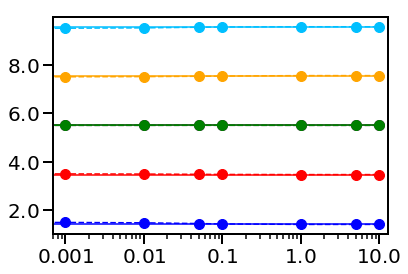

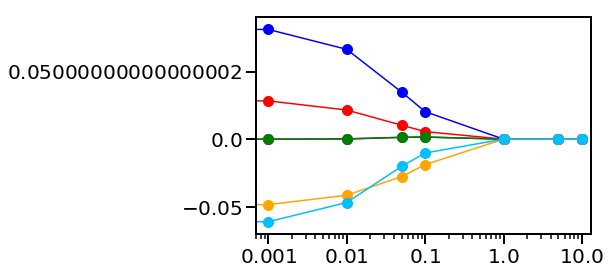

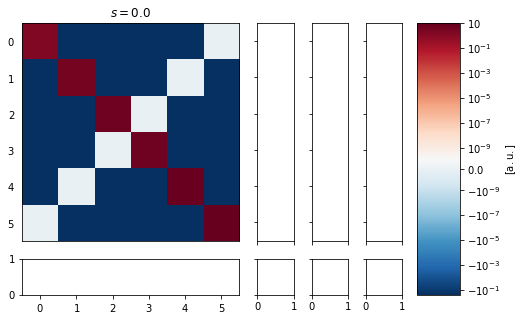

In [23]:
#!/usr/bin/env python

#------------------------------------------------------------------------------
# srg_pairing.py
#
# author:   H. Hergert 
# version:  1.1.0
# date:     Nov 18, 2016
# 
# tested with Python v2.7
# 
# Solves the pairing model for four particles in a basis of four doubly 
# degenerate states by means of a Similarity Renormalization Group (SRG)
# flow.
#
#------------------------------------------------------------------------------


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import SymLogNorm, Normalize
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

import numpy as np
from numpy import array, dot, diag, reshape
from scipy.linalg import eigvalsh
from scipy.integrate import odeint

#------------------------------------------------------------------------------
# plot helpers
#------------------------------------------------------------------------------
def myLabels(x, pos):
    '''format tick labels using LaTeX-like math fonts'''
    return '$%s$'%x

def myPlotSettings(ax, formatter):
    '''save these settings for use in other plots'''
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='both',which='major',width=1.5,length=8)
    ax.tick_params(axis='both',which='minor',width=1.5,length=5)
    ax.tick_params(axis='both',width=2,length=10,labelsize=20)
    for s in ['left', 'right', 'top', 'bottom']:
        ax.spines[s].set_linewidth(2)
    ax.set_xlim([0.0007,13])  
    return

#------------------------------------------------------------------------------
# plot routines
#------------------------------------------------------------------------------
def plot_diagonals(data, eigenvalues, flowparams, delta, g):
    '''plot eigenvalues and diagonals'''
    dim       = len(data)
    formatter = FuncFormatter(myLabels)
    markers   = ['o' for i in range(dim)]
    cols      = ['blue', 'red', 'purple', 'green', 'orange', 'deepskyblue']

    # diagonals vs. eigenvalues on absolute scale
    fig, ax = plt.subplots()
    for i in range(dim):
        plt.semilogx(flowparams, [eigenvalues[i] for e in range(flowparams.shape[0])], color=cols[i], linestyle='solid')
        plt.semilogx(flowparams, data[i], color=cols[i], linestyle='dashed', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()

    # difference between diagonals and eigenvalues
    fig, ax = plt.subplots()
    for i in range(dim):
        plot_diff = plt.semilogx(flowparams, data[i]-eigenvalues[i], color=cols[i], linestyle='solid', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag-eval_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()
    return

#------------------------------------------------------------------------------
# plot matrix snapshots
#------------------------------------------------------------------------------
def plot_snapshots(Hs, flowparams, delta, g):
    fig  = plt.figure(1, (10., 5.))
    grid = AxesGrid(fig, 111,                       # similar to subplot(111)
                     nrows_ncols=(2, Hs.shape[0]/2),  # creates grid of axes
                     axes_pad=0.25,                 # pad between axes in inch.
                     label_mode='L',                # put labels on left, bottom
                     cbar_mode='single',            # one color bar (default: right of last image in grid)
                     cbar_pad=0.20,                 # insert space between plots and color bar
                     cbar_size='10%'                # size of colorbar relative to last image
                     )

    # create individual snapshots - figures are still addressed by single index,
    # despite multi-row grid
    for s in range(Hs.shape[0]):
        img = grid[s].imshow(Hs[s], 
                            cmap=plt.get_cmap('RdBu_r'),                                  # choose color map
                            interpolation='nearest',       
                            norm=SymLogNorm(linthresh=1e-10,vmin=-0.5*g,vmax=10*delta),   # normalize 
                            vmin=-0.5*g,                                                  # min/max values for data
                            vmax=10*delta
                            )

        # tune plots: switch off tick marks, ensure that plots retain aspect ratio
        grid[s].set_title('$s=%s$'%flowparams[s])
        grid[s].tick_params(      
  
        bottom='off',      
        top='off',
        left='off',      
        right='off'
        )
  
        grid[s].set_xticks([0,1,2,3,4,5])
        grid[s].set_yticks([0,1,2,3,4,5])
        grid[s].set_xticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])
        grid[s].set_yticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])

        cbar = grid.cbar_axes[0]
        plt.colorbar(img, cax=cbar, 
          ticks=[ -1.0e-1, -1.0e-3, -1.0e-5, -1.0e-7, -1.09e-9 , 0., 
                 1.0e-9, 1.0e-7, 1.0e-5, 1.0e-3, 0.1, 10.0]
        )

        cbar.axes.set_yticklabels(['$-10^{-1}$', '$-10^{-3}$', '$-10^{-5}$', '$-10^{-7}$', 
                             '$-10^{-9}$', '$0.0$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', 
                             '$10^{-3}$', '$10^{-1}$', '$10$'])
        cbar.set_ylabel('$\mathrm{[a. u.]}$') 


        plt.savefig("srg_pairing_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
        plt.show()
        
        return



# Hamiltonian for the pairing model
def Hamiltonian(delta,g):
    
    H = array(
        [[2*delta-g, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 0.],
         [-0.5*g, 4*delta-g, -0.5*g, -0.5*g, 0., -0.5*g],
         [-0.5*g, -0.5*g, 6*delta-g, 0., -0.5*g, -0.5*g],
         [-0.5*g, -0.5*g, 0., 6*delta-g, -0.5*g, -0.5*g],
         [-0.5*g, 0., -0.5*g, -0.5*g, 8*delta-g, -0.5*g],
         [0., -0.5*g, -0.5*g, -0.5*g, -0.5*g, 10*delta-g]])
    
    return H

# commutator of matrices
def commutator(a,b):
    
    return dot(a,b) - dot(b,a)

# right-hand side of the flow equation

g     = 0.5
delta = 1
    
H0    = Hamiltonian(delta, g)
dim   = H0.shape[0]

def derivative(y, dim):
    Om = reshape(y, (dim, dim))

    H = np.linalg.multi_dot([expm(Om),H0,expm(-Om)])
    
    Hd = diag(diag(H))
    
    Hod = H-Hd
    
    eta = commutator(H, Hod)
    
    ad = eta
    
    dOm = ad
    
    for i in range(1):
        
        ad = commutator(Om, ad)
        
        dOm = dOm + bernoulli(i+1)/math.factorial(i+1)*ad

    dydt = reshape(dOm, -1)
    
    return dydt
    

#-------------------------------------
# Main program
#-------------------------------------
def main():
    
    #calculate exact eigenvalues
    eigenvalues = eigvalsh(H0)
    
    # turn initial Hamiltonian into a linear array
    y0 = reshape(np.zeros((6,6)), -1)
    
    # flow parameters for snapshot images
    flowparams = array([0.,0.001,0.01,0.05,0.1,1.,5.,10.])
    
    ds = 0.001
    ys = y0
    ys_list = [y0]
    
    for i in range(10000):
        
        ys = ys + derivative(ys, dim)*ds
        
        if i == 0:
            ys_list.append(ys)
            
        if i == 9:
            ys_list.append(ys)
            
        if i == 49:
            ys_list.append(ys)
        
        if i == 99:
            ys_list.append(ys)
        
        if i == 999:
            ys_list.append(ys)
            
        if i == 4999:
            ys_list.append(ys)
            
        if i == 9999:
            ys_list.append(ys)
    
    # integrate flow eqautions - odeint returns an array of solutions, which are 1d arrays themselves
    # ys = odeint(derivative, y0, flowparams, args=(dim,))
    
    # reshape individual solution vectors into dim x dim Hamiltonian matrices
    
    Us = reshape(ys_list, (-1, dim,dim))
    
    Hs = np.zeros((8,6,6))
    
    for i in range(8):
        Hs[i] = np.linalg.multi_dot([expm(Us[i]),H0,expm(-Us[i])])
        
    data = []
    data = []
    for h in Hs:
        data.append(diag(h))
    data = zip(*data)

    plot_diagonals(data, eigenvalues, flowparams, delta, g)
    plot_snapshots(Hs, flowparams, delta, g)

#------------------------------------------------------------------------------
# make executable
#------------------------------------------------------------------------------
if __name__ == "__main__": 
    main()

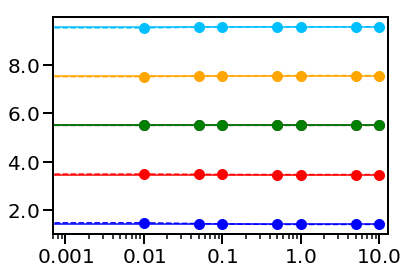

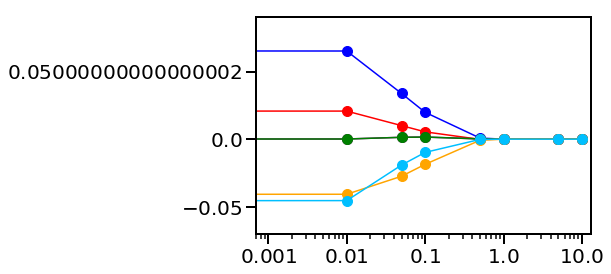

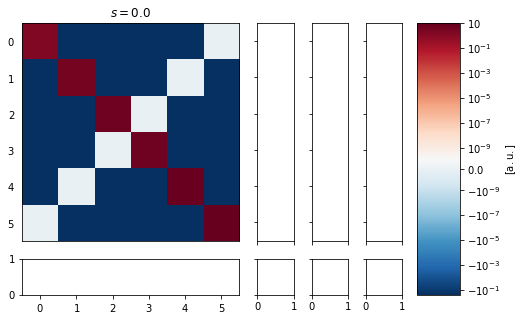

In [9]:
#!/usr/bin/env python

#------------------------------------------------------------------------------
# srg_pairing.py
#
# author:   H. Hergert 
# version:  1.1.0
# date:     Nov 18, 2016
# 
# tested with Python v2.7
# 
# Solves the pairing model for four particles in a basis of four doubly 
# degenerate states by means of a Similarity Renormalization Group (SRG)
# flow.
#
#------------------------------------------------------------------------------


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import SymLogNorm, Normalize
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

import numpy as np
from numpy import array, dot, diag, reshape
from scipy.linalg import eigvalsh
from scipy.integrate import odeint

#------------------------------------------------------------------------------
# plot helpers
#------------------------------------------------------------------------------
def myLabels(x, pos):
    '''format tick labels using LaTeX-like math fonts'''
    return '$%s$'%x

def myPlotSettings(ax, formatter):
    '''save these settings for use in other plots'''
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='both',which='major',width=1.5,length=8)
    ax.tick_params(axis='both',which='minor',width=1.5,length=5)
    ax.tick_params(axis='both',width=2,length=10,labelsize=20)
    for s in ['left', 'right', 'top', 'bottom']:
        ax.spines[s].set_linewidth(2)
    ax.set_xlim([0.0007,13])  
    return

#------------------------------------------------------------------------------
# plot routines
#------------------------------------------------------------------------------
def plot_diagonals(data, eigenvalues, flowparams, delta, g):
    '''plot eigenvalues and diagonals'''
    dim       = len(data)
    formatter = FuncFormatter(myLabels)
    markers   = ['o' for i in range(dim)]
    cols      = ['blue', 'red', 'purple', 'green', 'orange', 'deepskyblue']

    # diagonals vs. eigenvalues on absolute scale
    fig, ax = plt.subplots()
    for i in range(dim):
        plt.semilogx(flowparams, [eigenvalues[i] for e in range(flowparams.shape[0])], color=cols[i], linestyle='solid')
        plt.semilogx(flowparams, data[i], color=cols[i], linestyle='dashed', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()

    # difference between diagonals and eigenvalues
    fig, ax = plt.subplots()
    for i in range(dim):
        plot_diff = plt.semilogx(flowparams, data[i]-eigenvalues[i], color=cols[i], linestyle='solid', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag-eval_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()
    return

#------------------------------------------------------------------------------
# plot matrix snapshots
#------------------------------------------------------------------------------
def plot_snapshots(Hs, flowparams, delta, g):
    fig  = plt.figure(1, (10., 5.))
    grid = AxesGrid(fig, 111,                       # similar to subplot(111)
                     nrows_ncols=(2, Hs.shape[0]/2),  # creates grid of axes
                     axes_pad=0.25,                 # pad between axes in inch.
                     label_mode='L',                # put labels on left, bottom
                     cbar_mode='single',            # one color bar (default: right of last image in grid)
                     cbar_pad=0.20,                 # insert space between plots and color bar
                     cbar_size='10%'                # size of colorbar relative to last image
                     )

    # create individual snapshots - figures are still addressed by single index,
    # despite multi-row grid
    for s in range(Hs.shape[0]):
        img = grid[s].imshow(Hs[s], 
                            cmap=plt.get_cmap('RdBu_r'),                                  # choose color map
                            interpolation='nearest',       
                            norm=SymLogNorm(linthresh=1e-10,vmin=-0.5*g,vmax=10*delta),   # normalize 
                            vmin=-0.5*g,                                                  # min/max values for data
                            vmax=10*delta
                            )

        # tune plots: switch off tick marks, ensure that plots retain aspect ratio
        grid[s].set_title('$s=%s$'%flowparams[s])
        grid[s].tick_params(      
  
        bottom='off',      
        top='off',
        left='off',      
        right='off'
        )
  
        grid[s].set_xticks([0,1,2,3,4,5])
        grid[s].set_yticks([0,1,2,3,4,5])
        grid[s].set_xticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])
        grid[s].set_yticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])

        cbar = grid.cbar_axes[0]
        plt.colorbar(img, cax=cbar, 
          ticks=[ -1.0e-1, -1.0e-3, -1.0e-5, -1.0e-7, -1.09e-9 , 0., 
                 1.0e-9, 1.0e-7, 1.0e-5, 1.0e-3, 0.1, 10.0]
        )

        cbar.axes.set_yticklabels(['$-10^{-1}$', '$-10^{-3}$', '$-10^{-5}$', '$-10^{-7}$', 
                             '$-10^{-9}$', '$0.0$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', 
                             '$10^{-3}$', '$10^{-1}$', '$10$'])
        cbar.set_ylabel('$\mathrm{[a. u.]}$') 


        plt.savefig("srg_pairing_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
        plt.show()
        
        return



# Hamiltonian for the pairing model
def Hamiltonian(delta,g):
    
    H = array(
        [[2*delta-g, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 0.],
         [-0.5*g, 4*delta-g, -0.5*g, -0.5*g, 0., -0.5*g],
         [-0.5*g, -0.5*g, 6*delta-g, 0., -0.5*g, -0.5*g],
         [-0.5*g, -0.5*g, 0., 6*delta-g, -0.5*g, -0.5*g],
         [-0.5*g, 0., -0.5*g, -0.5*g, 8*delta-g, -0.5*g],
         [0., -0.5*g, -0.5*g, -0.5*g, -0.5*g, 10*delta-g]])
    
    return H

# commutator of matrices
def commutator(a,b):
    
    return dot(a,b) - dot(b,a)

# right-hand side of the flow equation

g     = 0.5
delta = 1
    
H0    = Hamiltonian(delta, g)
dim   = H0.shape[0]

def derivative(y, dim):
    Om = reshape(y, (dim, dim))

    H = np.linalg.multi_dot([expm(Om),H0,expm(-Om)])
    
    Hd = diag(diag(H))
    
    Hod = H-Hd
    
    eta = commutator(H, Hod)
    
    ad = eta
    
    dOm = ad
    
    for i in range(10):
        
        ad = commutator(Om, ad)
        
        dOm = dOm + bernoulli(i+1)/math.factorial(i+1)*ad

    dydt = reshape(dOm, -1)
    
    return dydt
    

#-------------------------------------
# Main program
#-------------------------------------
def main():
    
    #calculate exact eigenvalues
    eigenvalues = eigvalsh(H0)
    
    # turn initial Hamiltonian into a linear array
    y0 = reshape(np.zeros((6,6)), -1)
    
    # flow parameters for snapshot images
    flowparams = array([0.,0.01,0.05,0.1,0.5,1.,5.,10.])
    
    ds = 0.01
    ys = y0
    ys_list = [y0]
    
    for i in range(1000):
        
        ys = ys + derivative(ys, dim)*ds
        
        if i == 0:
            ys_list.append(ys)
            
        if i == 4:
            ys_list.append(ys)
            
        if i == 9:
            ys_list.append(ys)
        
        if i == 49:
            ys_list.append(ys)
        
        if i == 99:
            ys_list.append(ys)
            
        if i == 499:
            ys_list.append(ys)
            
        if i == 999:
            ys_list.append(ys)
    
    # integrate flow eqautions - odeint returns an array of solutions, which are 1d arrays themselves
    # ys = odeint(derivative, y0, flowparams, args=(dim,))
    
    # reshape individual solution vectors into dim x dim Hamiltonian matrices
    
    Us = reshape(ys_list, (-1, dim,dim))
    
    Hs = np.zeros((8,6,6))
    
    for i in range(8):
        Hs[i] = np.linalg.multi_dot([expm(Us[i]),H0,expm(-Us[i])])
        
    data = []
    data = []
    for h in Hs:
        data.append(diag(h))
    data = zip(*data)

    plot_diagonals(data, eigenvalues, flowparams, delta, g)
    plot_snapshots(Hs, flowparams, delta, g)

#------------------------------------------------------------------------------
# make executable
#------------------------------------------------------------------------------
if __name__ == "__main__": 
    main()